### 1) extract text from PDFs 

In [15]:
# src/extract_pdf.py
from pypdf import PdfReader
from pathlib import Path

def extract_text_from_pdf(pdf_path):
    reader = PdfReader(pdf_path)
    pages = []
    for p in reader.pages:
        text = p.extract_text() or ""
        pages.append(text)
    return "\n\n".join(pages)

def save_text(pdf_path: str, out_txt_path: str):
    out = Path(out_txt_path)
    out.parent.mkdir(parents=True, exist_ok=True)
    text = extract_text_from_pdf(pdf_path=pdf_path)
    out.write_text(text, encoding="utf-8")

if __name__ == "__main__":
    pdfs = {
        "automotivespice": "../data/raw/Automotive_SPICE_PAM_31_EN.pdf",
        "autosar_ecum": "../data/raw/AUTOSAR_SWS_ECUStateManager.pdf",
    }
    for name, p in pdfs.items():
        save_text(p, f"../data/txt/{name}.txt")
        print("Saved:", name)


Saved: automotivespice
Saved: autosar_ecum


### 2) Parse handling convert text to Markdown 

In [16]:
# src/parse_headings.py
import re, uuid
from pathlib import Path
from typing import List, Dict

# flexible regexes (you can extend them)
numbered_header_re = re.compile(
    r"^\s*(\d+(?:\.\d+){0,3})\s*\.?\s+(?P<title>[A-Z][^\n]{3,200})$", re.M
)
code_header_re = re.compile(r"^(?P<code>[A-Z]{2,6}\.\d+)\s+(?P<title>.+)$", re.M)
allcaps_re = re.compile(r"^[A-Z0-9 \-]{3,200}$", re.M)

def parse_numbered_headings(text: str) -> List[Dict]:
    """
    Return list of chunks: {id, level, title, parent_id, parent_num, content}
    Slices content from end(header_i) -> start(header_{i+1})
    """
    matches = list(numbered_header_re.finditer(text))
    if not matches:
        matches = list(code_header_re.finditer(text))
    # fallback: any ALL-CAPS lines as headings (best-effort)
    if not matches:
        matches = list(allcaps_re.finditer(text))

    if not matches:
        return [{
            "id": str(uuid.uuid4()),
            "level": 1,
            "title": "Document",
            "parent_id": None,
            "parent_num": None,
            "content": text.strip(),
        }]

    chunks = []
    boundaries = [(m.start(), m.end(), m.group(0), (m.groupdict().get("title") or m.group(0)).strip()) for m in matches]
    boundaries.append((len(text), len(text), "", ""))

    for i in range(len(boundaries)-1):
        header_line = boundaries[i][2]
        title = boundaries[i][3].strip()
        content = text[boundaries[i][1]:boundaries[i+1][0]].strip()
        num_match = re.match(r"^\s*(\d+(?:\.\d+)*)", header_line)
        level = num_match.group(1).count(".")+1 if num_match else 2
        chunks.append({
            "id": str(uuid.uuid4()),
            "level": level,
            "title": title,
            "parent_num": num_match.group(1) if num_match else None,
            "parent_id": None,   # fill later
            "content": content,
        })

    # link parents by numeric prefix
    for c in chunks:
        pnum = c.get("parent_num")
        if pnum:
            parts = pnum.split(".")
            found_parent = None
            for candidate in reversed(chunks):
                cp = candidate.get("parent_num")
                if cp and cp == ".".join(parts[:-1]):
                    found_parent = candidate["id"]
                    break
            c["parent_id"] = found_parent
        else:
            c["parent_id"] = None
    return chunks

def save_markdown(chunks, out_md_path):
    out_md_path = Path(out_md_path)
    out_md_path.parent.mkdir(parents=True, exist_ok=True)
    lines = []
    for c in chunks:
        header_prefix = "#" * max(1, c["level"])
        lines.append(f"{header_prefix} {c['title']}\n")
        lines.append(c["content"] + "\n\n")
    out_md_path.write_text("\n".join(lines), encoding="utf-8")


### 3) Build Graph 
#### add nodes for each level 

In [18]:
# src/build_graph.py
import networkx as nx
from pathlib import Path
import uuid, json, pickle

def build_graph_from_md(md_path: str):
    text = Path(md_path).read_text(encoding="utf-8")
    chunks = parse_numbered_headings(text)
    G = nx.DiGraph()
    standard_id = str(uuid.uuid4())
    G.add_node(standard_id,
               title=Path(md_path).stem,
               level=0, type="standard", source=str(md_path), content="")
    for c in chunks:
        node_id = c["id"]
        G.add_node(node_id,
                   title=c["title"],
                   level=c["level"],
                   type=("part" if c["level"] == 1 else "clause"),
                   content=c["content"],
                   source=str(md_path))
        parent_id = c.get("parent_id")
        if parent_id:
            # if parent_id string not in G yet (different UUID), fallback to connect to standard
            if parent_id in G.nodes:
                G.add_edge(parent_id, node_id)
            else:
                G.add_edge(standard_id, node_id)
        else:
            G.add_edge(standard_id, node_id)
    return G

def merge_graphs(graphs):
    G = nx.DiGraph()
    for g in graphs:
        G = nx.compose(G, g)
    return G

if __name__ == "__main__":
    md_dir = Path("../data/md")
    graphs = []
    for md in md_dir.glob("*.md"):
        g = build_graph_from_md(str(md))
        graphs.append(g)
    G = merge_graphs(graphs)
    out_dir = Path("../data/graphs")
    out_dir.mkdir(parents=True, exist_ok=True)
    with open(out_dir / "standards_graph.gpickle", "wb") as f:
        pickle.dump(G, f)
    nodes = {n: dict(G.nodes[n]) for n in G.nodes()}
    (out_dir / "standards_graph_nodes.json").write_text(json.dumps(nodes, ensure_ascii=False, indent=2), encoding="utf-8")
    print("Graph saved:", out_dir / "standards_graph.gpickle")


Graph saved: ..\data\graphs\standards_graph.gpickle


### 4) build index 
####  Resolution: We store embeddings for each clause node (or for each node). Then map faiss idx → graph node id. 

In [23]:
# src/build_index.py
from sentence_transformers import SentenceTransformer
import faiss, numpy as np
import networkx as nx
import json, pickle
from pathlib import Path

EMB_MODEL = "sentence-transformers/all-MiniLM-L6-v2"

def build_index_from_graph(graph_pickle_path, out_dir="../outputs/indices", index_name="graph_index"):
    out_dir = Path(out_dir)  # ✅ convert to Path
    out_dir.mkdir(parents=True, exist_ok=True)

    # load graph
    with open(graph_pickle_path, "rb") as f:
        G = pickle.load(f)

    # choose nodes to embed (clause & part)
    nodes_to_embed = [n for n, d in G.nodes(data=True) if d.get("type") in ("clause", "part")]
    texts = [(G.nodes[n]["content"] or G.nodes[n]["title"]).strip() for n in nodes_to_embed]

    # encode embeddings
    model = SentenceTransformer(EMB_MODEL)
    embeddings = model.encode(texts, show_progress_bar=True, convert_to_numpy=True)
    faiss.normalize_L2(embeddings)

    # build FAISS index
    d = embeddings.shape[1]
    index = faiss.IndexFlatIP(d)
    index.add(embeddings)

    # save FAISS index
    idx_path = out_dir / f"{index_name}.index"
    faiss.write_index(index, str(idx_path))

    # save mapping from FAISS id -> node_id & metadata
    mapping = {i: {"node_id": node, **G.nodes[node]} for i, node in enumerate(nodes_to_embed)}
    meta_path = out_dir / f"{index_name}_meta.json"
    meta_path.write_text(json.dumps(mapping, ensure_ascii=False, indent=2), encoding="utf-8")

    print("Saved FAISS index:", idx_path)
    print("Saved metadata JSON:", meta_path)

    return str(idx_path), str(meta_path)


if __name__ == "__main__":
    build_index_from_graph(
        "../data/graphs/standards_graph.gpickle",
        out_dir="../outputs/indices",
        index_name="graph_index"
    )


Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Saved FAISS index: ..\outputs\indices\graph_index.index
Saved metadata JSON: ..\outputs\indices\graph_index_meta.json


### 4) graph Retrieval
#### 3 types:( A) Graph-first , B) Semantic-first, C) Hybrid)

In [24]:
# src/retrieval_graph.py
import faiss, json, pickle
import networkx as nx
from sentence_transformers import SentenceTransformer
from pathlib import Path
from collections import deque

EMB_MODEL = "sentence-transformers/all-MiniLM-L6-v2"

class GraphRAG:
    def __init__(self, graph_pickle, index_path, meta_path, emb_model=EMB_MODEL):
        with open(graph_pickle, "rb") as f:
            self.G = pickle.load(f)
        self.index = faiss.read_index(index_path)
        self.meta = json.loads(Path(meta_path).read_text(encoding="utf-8"))
        self.model = SentenceTransformer(emb_model)
        self.faiss_to_node = {int(k): v["node_id"] for k,v in self.meta.items()}

    def _embed(self, q):
        v = self.model.encode([q], convert_to_numpy=True)
        faiss.normalize_L2(v)
        return v

    def semantic_search(self, query, k=5):
        v = self._embed(query)
        D, I = self.index.search(v, k)
        results = []
        for score, idx in zip(D[0], I[0]):
            if idx == -1: continue
            node_id = self.faiss_to_node[int(idx)]
            results.append({"node": node_id, "score": float(score), **dict(self.G.nodes[node_id])})
        return results

    def expand_context(self, node_id, max_hops=1):
        q = deque([(node_id,0)])
        seen = {node_id}
        nodes = [node_id]
        while q:
            cur, dist = q.popleft()
            if dist >= max_hops: continue
            for nbr in list(self.G.predecessors(cur))+list(self.G.successors(cur)):
                if nbr not in seen:
                    seen.add(nbr)
                    nodes.append(nbr)
                    q.append((nbr, dist+1))
        return [{"node": n, **dict(self.G.nodes[n])} for n in nodes]

    def hybrid_retrieve(self, query, top_k_sem=5, expand_hops=1, max_nodes=20):
        sem = self.semantic_search(query, k=top_k_sem)
        context_nodes = []
        for r in sem:
            context_nodes.extend(self.expand_context(r["node"], max_hops=expand_hops))
        # deduplicate preserving order
        seen = set()
        dedup = []
        for n in context_nodes:
            if n["node"] in seen: continue
            seen.add(n["node"])
            dedup.append(n)
        return dedup[:max_nodes]

    # graph-first: find nodes by title/code exact match, then expand
    def graph_first(self, code_or_title, expand_hops=2, max_nodes=30):
        # find nodes where title contains given token (case-insensitive)
        matches = [n for n,d in self.G.nodes(data=True) if code_or_title.lower() in str(d.get("title","")).lower()]
        context_nodes = []
        for m in matches:
            context_nodes.extend(self.expand_context(m, max_hops=expand_hops))
        # dedup
        seen = set(); out=[]
        for n in context_nodes:
            if n["node"] in seen: continue
            seen.add(n["node"]); out.append(n)
        return out[:max_nodes]


LLM Layer 

In [25]:
# demo_graph_rag.py (or run in a notebook cell)
import os
from dotenv import load_dotenv
load_dotenv()
from pathlib import Path
import textwrap

GRAPH_PKL = "../data/graphs/standards_graph.gpickle"
INDEX_PATH = "../outputs/indices/graph_index.index"
META_PATH = "../outputs/indices/graph_index_meta.json"

rag = GraphRAG(GRAPH_PKL, INDEX_PATH, META_PATH)

# choose retrieval strategy
query = "What does SYS.2 require?"
nodes = rag.hybrid_retrieve(query, top_k_sem=6, expand_hops=1, max_nodes=10)
print("Retrieved nodes (count):", len(nodes))
for n in nodes:
    print("-", n["title"], "| type:", n.get("type"), "| snippet:", (n.get("content") or "")[:120].replace("\n"," "))

# build context (concatenate title + content, trimming if too long)
def build_context_from_nodes(nodes, max_chars=7000):
    parts = []
    total = 0
    for n in nodes:
        txt = f"{n.get('title','')}\n{n.get('content','')}".strip()
        if not txt: continue
        if total + len(txt) > max_chars:
            break
        parts.append(txt)
        total += len(txt)
    return "\n\n".join(parts)

context = build_context_from_nodes(nodes, max_chars=6000)
print("\n--- Context length:", len(context))

# LLM call (Gemini via langchain_google_genai)
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.schema import SystemMessage, HumanMessage
GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")
llm = ChatGoogleGenerativeAI(api_key=GEMINI_API_KEY, model="gemini-2.5-pro", temperature=0.2, max_retries=2)

system_prompt = SystemMessage(content="You are an expert in Automotive SPICE and AUTOSAR. Use the context to answer precisely and cite clause titles when possible.")
human_prompt = HumanMessage(content=f"Context:\n{context}\n\nQuestion: {query}")

# use invoke to avoid deprecation warning
resp = llm.invoke([system_prompt, human_prompt])
print("\n=== LLM ANSWER ===\n")
print(resp.content)


c:\Users\LAPSHOP\anaconda3\envs\slrag\Lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Retrieved nodes (count): 7
- SYS.2 | type: clause | snippet: 
- automotivespice | type: standard | snippet: 
- SYS.5 | type: clause | snippet: 
- Reuse Program | type: clause | snippet: Management System Engineering Process Group (SYS)
- System level | type: clause | snippet: 
- Software Qualification Test | type: clause | snippet: SYS.2.BP5: Verification criteria SWE.1.BP5: Verification criteria SWE.5.BP3: Compliance SYS.4.BP3: Compliance SWE.4.BP2:
- Product Release | type: clause | snippet: Table 3 — Primary life cycle processes – SPL process group  The System Engineering process group (SYS) consists of proce

--- Context length: 609

=== LLM ANSWER ===

Based on the provided context, SYS.2 is a process within the **System Engineering Process Group (SYS)**.

The specific requirement mentioned for this process is:

*   **SYS.2.BP5: Verification criteria**: This requires the development of verification criteria for system requirements to demonstrate that the requirements have been met

Visualization (PNG + interactive HTML) — export

In [26]:
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path
import pickle

def save_static_png(graph_pickle, out_png="../outputs/graphs/graph_overview.png"):
    with open(graph_pickle, "rb") as f:
        G = pickle.load(f)
    plt.figure(figsize=(12,9))
    pos = nx.spring_layout(G, k=0.3, iterations=100)
    levels = [G.nodes[n].get("level",0) for n in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_size=60, cmap=plt.cm.viridis, node_color=levels)
    labels = {n: (G.nodes[n].get("title")[:30] + ("..." if len(G.nodes[n].get("title",""))>30 else "")) for n in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels, font_size=6)
    nx.draw_networkx_edges(G, pos, alpha=0.3)
    Path(out_png).parent.mkdir(parents=True, exist_ok=True)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(out_png, dpi=300)
    plt.close()
    print("Saved PNG:", out_png)

# interactive via pyvis
from pyvis.network import Network
def save_interactive_html(graph_pickle, out_html="../outputs/graphs/graph_visual.html"):
    with open(graph_pickle, "rb") as f:
        G = pickle.load(f)
    net = Network(height="800px", width="100%", notebook=False)
    for n,d in G.nodes(data=True):
        title = d.get("title","")
        content = (d.get("content") or "")[:300]
        net.add_node(n, label=title, title=content, group=d.get("level",0))
    for u,v in G.edges():
        net.add_edge(u,v)
    Path(out_html).parent.mkdir(parents=True, exist_ok=True)
    net.show(out_html)
    print("Saved HTML:", out_html)


In [28]:
from pathlib import Path
for t in Path("../data/txt").glob("*.txt"):
    chunks = parse_numbered_headings(t.read_text(encoding="utf-8"))
    save_markdown(chunks, Path("../data/md")/t.with_suffix(".md").name)


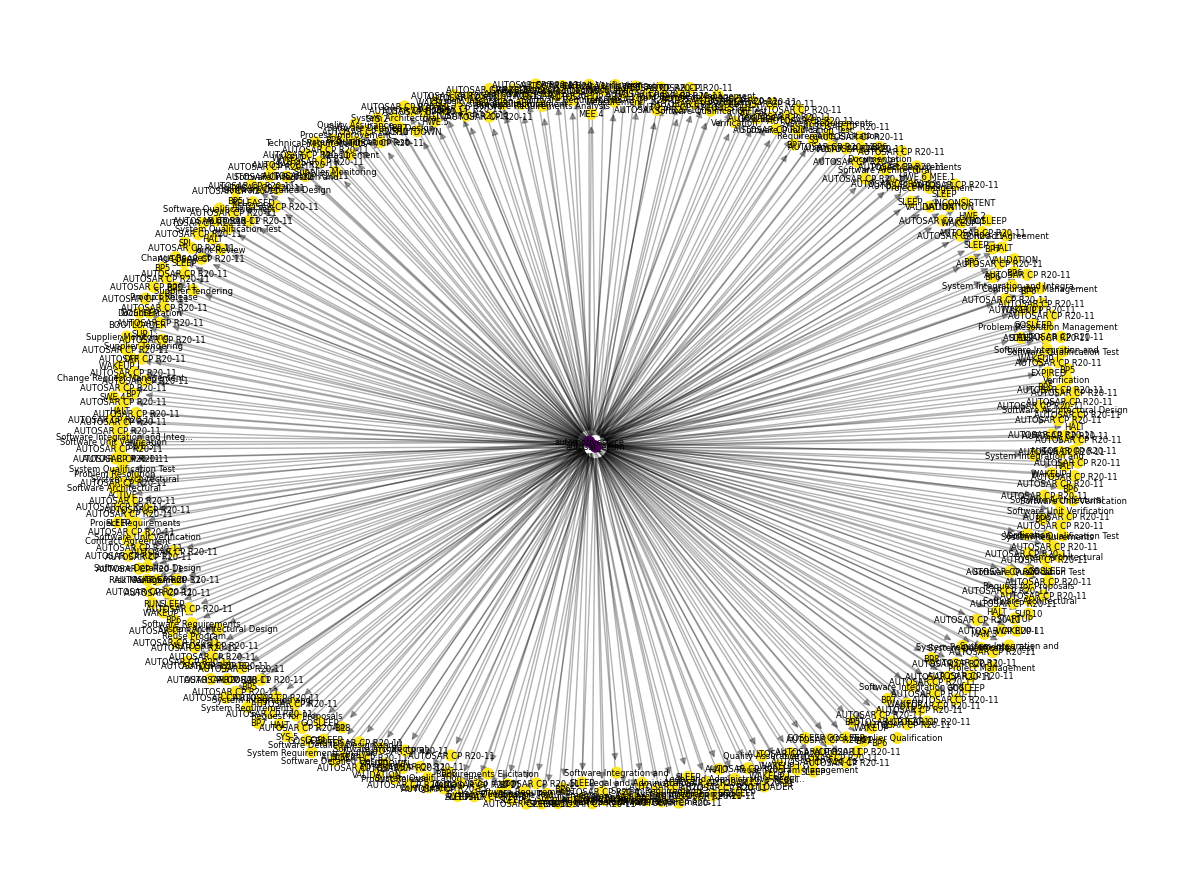

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image, display
from pathlib import Path
import pickle
import networkx as nx

png_path = Path("../outputs/graphs/graph_overview.png")

if png_path.exists():
    display(Image(filename=str(png_path)))

graph_pickle = Path("../data/graphs/standards_graph.gpickle")
with open(graph_pickle, "rb") as f:
    G = pickle.load(f)

plt.figure(figsize=(12,9))
pos = nx.spring_layout(G, k=0.3, iterations=100)
levels = [G.nodes[n].get("level",0) for n in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=60, cmap=plt.cm.viridis, node_color=levels)
labels = {n: (G.nodes[n].get("title")[:30] + ("..." if len(G.nodes[n].get("title",""))>30 else "")) for n in G.nodes()}
nx.draw_networkx_labels(G, pos, labels, font_size=6)
nx.draw_networkx_edges(G, pos, alpha=0.3)
plt.axis('off')
plt.tight_layout()
plt.show()
